# Setup and imports

The notebook was developed and tested with torch==2.6.0+cu124.

## Setup pointcloud libraries

In [ ]:
import os
!pip install trimesh pyvista
!pip install torch_geometric
!pip install huggingface_hub
!pip install pyg_lib torch_scatter torch_cluster -f https://data.pyg.org/whl/torch-2.6.0+cu124.html

In [2]:
import torch
import trimesh
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch.nn as nn
from scipy.spatial import cKDTree
import pandas as pd

torch.__version__

'2.6.0+cu124'

## Setup pre-made AB-UPT components
These will be used later on in the tutorial.

In [ ]:
!git clone https://github.com/Emmi-AI/anchored-branched-universal-physics-transformers.git

In [4]:
%cd anchored-branched-universal-physics-transformers/src

/content/anchored-branched-universal-physics-transformers/src


In [5]:
from abupt_collator import AbuptCollator
from drivaerml_dataset import DrivAerMLDataset
from model import AnchoredBranchedUPT
from preprocessors import MomentNormalizationPreprocessor, PositionNormalizationPreprocessor
from streamline_visualization import plot_streamlines
from utils import plot_pointcloud_single, plot_pointcloud_double, set_seed
from tqdm import tqdm

set_seed(0)

# Data download

First, we need to download the data which is hosted on [huggingface](https://huggingface.co/datasets/neashton/drivaerml).

We will only consider run_11, which is a design that we put into the testset.

In [6]:
sh = """
#!/bin/bash

# Set the path and prefix
HF_OWNER="neashton"
HF_PREFIX="drivaerml"

# Set the local directory to download the files
LOCAL_DIR="../data"

# Create the local directory if it doesn't exist
mkdir -p "$LOCAL_DIR"

# Loop through the run folders from 1 to 500
for i in $(seq 11 11); do
    RUN_DIR="run_$i"
    RUN_LOCAL_DIR="$LOCAL_DIR/$RUN_DIR"

    # Create the run directory if it doesn't exist
    mkdir -p "$RUN_LOCAL_DIR"

    # Download drivaer_i.stl (geometry file) and boundary_i.stl (surface variables)
    wget "https://huggingface.co/datasets/${HF_OWNER}/${HF_PREFIX}/resolve/main/$RUN_DIR/drivaer_$i.stl" -O "$RUN_LOCAL_DIR/drivaer_$i.stl"
    wget "https://huggingface.co/datasets/${HF_OWNER}/${HF_PREFIX}/resolve/main/$RUN_DIR/boundary_$i.vtp" -O "$RUN_LOCAL_DIR/boundary_$i.vtp"
    wget "https://huggingface.co/datasets/${HF_OWNER}/${HF_PREFIX}/resolve/main/$RUN_DIR/geo_ref_$i.csv" -O "$RUN_LOCAL_DIR/geo_ref_$i.csv"


done
"""
with open('download.sh', 'w') as file:
    file.write(sh)

In [ ]:
!bash download.sh

# Visualize geometry

In [8]:
# load geometry and surface data (from simulation) into memory
stl = trimesh.load("../data/run_11/drivaer_11.stl", force="mesh")

In [9]:
# interactive visualization of the STL geometry
#stl.show()

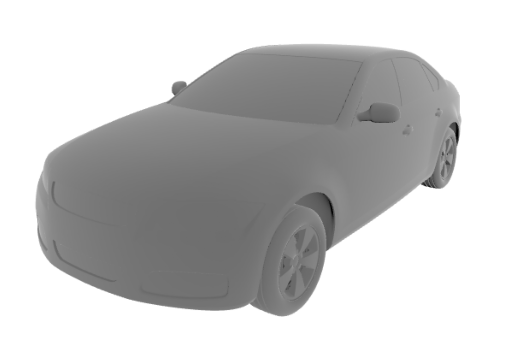

In [10]:
# static image of the geometry
img = mpimg.imread('../images/visualization_geometry_static.png')
plt.imshow(img)
plt.axis('off')
plt.show()

# Inspect data

Now that we know what we are working with, we can have a more detailed look at what we extract from the dataset and what shapes these items have. We also convert it to torch tensors such that we can easily load them afterwards with our `DrivaermlDataset` implementation in `src/drivaerml_dataset`.

## Surface-level

Surface-level data can be directly extracted from the `.vtp` file.

In [11]:
vtp = pv.read("../data/run_11/boundary_11.vtp")

7.8M points in 3D space
surface_position.shape: torch.Size([7792715, 3])


<Figure size 640x480 with 0 Axes>

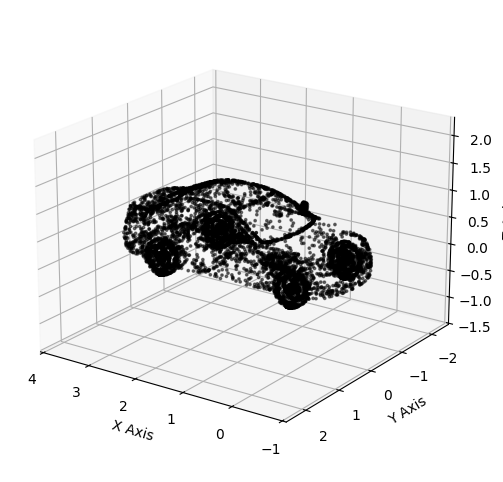

In [12]:
surface_position = torch.from_numpy(vtp.cell_centers().points)
print(f"{len(surface_position) / 1000 / 1000:.1f}M points in 3D space")
print(f"surface_position.shape: {surface_position.shape}")
torch.save(surface_position, "../data/run_11/surface_position_vtp.pt")
plot_pointcloud_single(
    surface_position,
    # increase this for higher resolution or larger plot
    num_points=10000,
    figsize=(6, 6)
)

7.8M points with a scalar pressure value
surface_pressure.shape: torch.Size([7792715])


<Figure size 640x480 with 0 Axes>

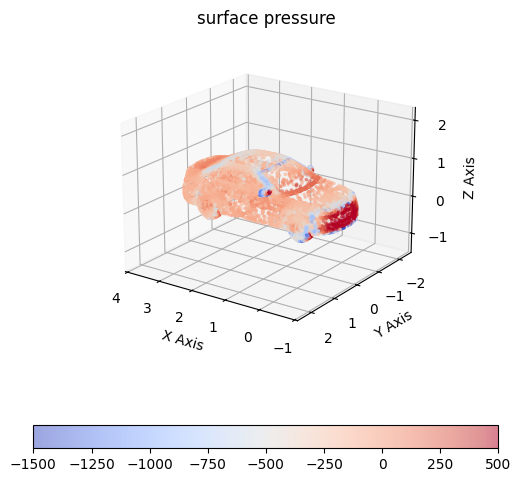

In [13]:
surface_pressure = torch.from_numpy(vtp.get_array("pMeanTrim"))
print(f"{len(surface_position) / 1000 / 1000:.1f}M points with a scalar pressure value")
print(f"surface_pressure.shape: {surface_pressure.shape}")
torch.save(surface_pressure, "../data/run_11/surface_pressure.pt")
plot_pointcloud_single(
    surface_position,
    # adjust clamp values for different color scale (original range is roughly -2500 to 700)
    color=surface_pressure.clamp(-1500, 500),
    title="surface pressure",
    # increas this for more fidelity/larger plot
    num_points=20000,
    figsize=(6, 6),
)

7.8M points with a 3D wallshearstress vector
wallshearstress.shape: torch.Size([7792715, 3])


<Figure size 640x480 with 0 Axes>

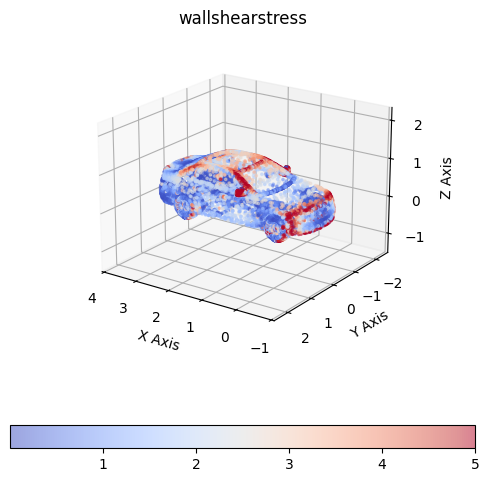

In [14]:
wallshearstress = torch.from_numpy(vtp.get_array("wallShearStressMeanTrim"))
print(f"{len(surface_position) / 1000 / 1000:.1f}M points with a 3D wallshearstress vector")
print(f"wallshearstress.shape: {wallshearstress.shape}")
torch.save(wallshearstress, "../data/run_11/surface_wallshearstress.pt")
plot_pointcloud_single(
    surface_position,
    # adjust clamp values for different color scale (original range is roughly 0 to 30)
    color=wallshearstress.norm(dim=1).clamp(0, 5),
    title="wallshearstress",
    # increas this for more fidelity/larger plot
    num_points=20000,
    figsize=(6, 6),
)

## Volume-level data
Volume-level data is quite large, so downloading and storing the full data is not feasible in colab. We therefore provide already preprocessed (1000x subsampled) volumetric data.

Note that 134K volume cells loaded here would be 134M in the raw data.

Also note that the CFD mesh highly resolves regions close to the surface, which makes the volume visualization look like a "silhouette" of the car.

134M volume points in 3D space
volume_position.shape: torch.Size([134142, 3])


<Figure size 640x480 with 0 Axes>

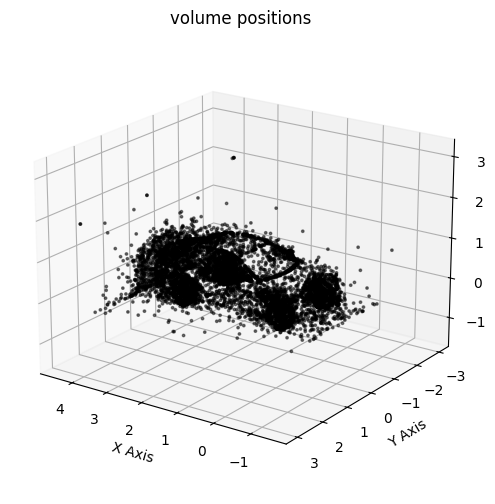

In [15]:
volume_position = torch.load("../data/run_11/volume_cell_position.pt")
print(f"{int(len(volume_position) / 1000)}M volume points in 3D space")
print(f"volume_position.shape: {volume_position.shape}")
# clamp volume positions for nicer visualization
volume_position_clamp = volume_position.clamp(torch.tensor([-1, -3, -1.5]), torch.tensor([4, 3, 2]))
plot_pointcloud_single(
    volume_position_clamp,
    title="volume positions",
    # increas this for more fidelity/larger plot
    num_points=10000,
    figsize=(6, 6),
)

We scale positions to have approximately range [0, 1000]. To do this, we use the min/max of the volume positions. For simplicity, we'll round them to [-40, 80]. You will see these values appear later when we normalize the coordinates.

134M scalar volume pressure values
volume_totalpcoeff.shape: torch.Size([134142])


<Figure size 640x480 with 0 Axes>

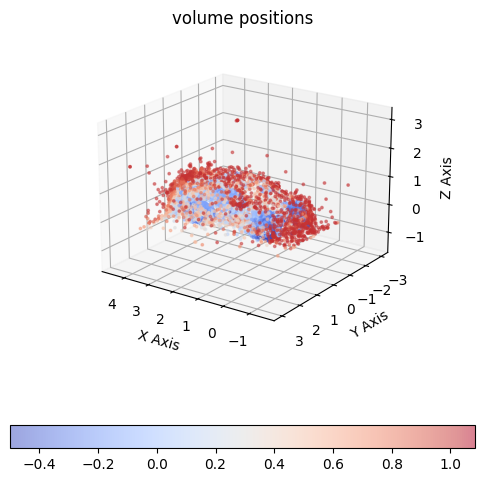

In [16]:
volume_totalpcoeff = torch.load("../data/run_11/volume_cell_totalpcoeff.pt")
print(f"{int(len(volume_totalpcoeff) / 1000)}M scalar volume pressure values")
print(f"volume_totalpcoeff.shape: {volume_totalpcoeff.shape}")
plot_pointcloud_single(
    volume_position_clamp,
    # clamp for nicer visualization (original range is roughly [-1.7, 1.1])
    color=volume_totalpcoeff.clamp(-0.5, 1.5),
    title="volume positions",
    # increas this for more fidelity/larger plot
    num_points=10000,
    figsize=(6, 6),
)

134M 3D velocity vectors
volume_velocity.shape: torch.Size([134142, 3])


<Figure size 640x480 with 0 Axes>

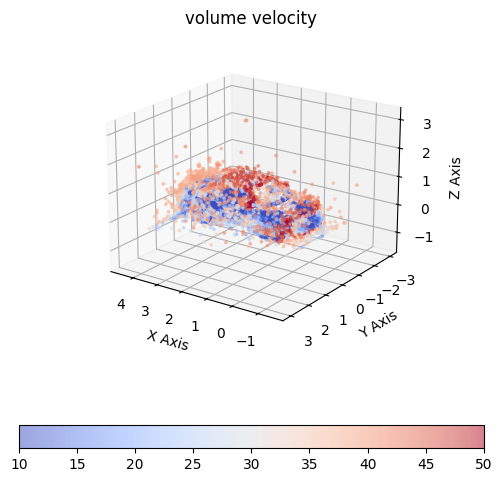

In [17]:
volume_velocity = torch.load("../data/run_11/volume_cell_velocity.pt")
print(f"{int(len(volume_totalpcoeff) / 1000)}M 3D velocity vectors")
print(f"volume_velocity.shape: {volume_velocity.shape}")
plot_pointcloud_single(
    volume_position_clamp,
    # clamp for nicer visualization (original range is roughly [0, 70])
    color=volume_velocity.norm(dim=1).clamp(10, 50),
    title="volume velocity",
    # increas this for more fidelity/larger plot
    num_points=10000,
    figsize=(6, 6),
)

volume_vorticity.shape: torch.Size([134142, 3])


<Figure size 640x480 with 0 Axes>

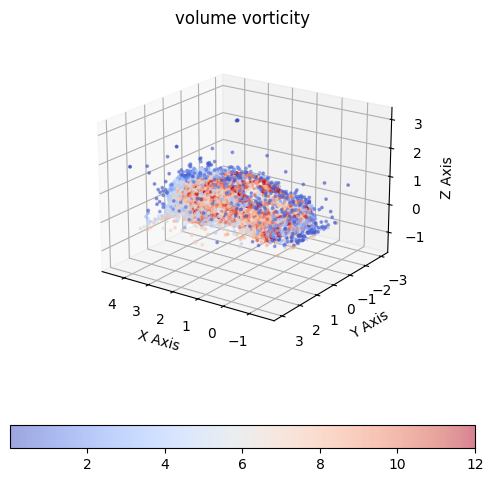

In [18]:
volume_vorticity = torch.load("../data/run_11/volume_cell_vorticity.pt")
print(f"volume_vorticity.shape: {volume_vorticity.shape}")
# we convert vorticity to logspace because the value range is so large (roughly 0 to 250000)
volume_vorticity_logscale = torch.sign(volume_vorticity) * torch.log1p(volume_vorticity.abs())
plot_pointcloud_single(
    volume_position_clamp,
    # clamp for nicer visualization (original range is roughly [0, 18])
    color=volume_vorticity_logscale.norm(dim=1).clamp(0, 12),
    title="volume vorticity",
    # increas this for more fidelity/larger plot
    num_points=10000,
    figsize=(6, 6),
)

# Preparing data for training/inference with AB-UPT

AB-UPT requires anchor tokens, which are randomly sampled points in the surface/volume.

We show how to do this on the example of surface points, but it is equivalent on volume points. So we randomly permute the surface points and split them into anchors and queries.

In [19]:
num_surface_anchors = 16384
surface_perm = torch.randperm(len(surface_position))
surface_anchor_idxs = surface_perm[:num_surface_anchors]
surface_query_idxs = surface_perm[num_surface_anchors:]
print(f"num_surface_anchors: {len(surface_anchor_idxs)}")
print(f"num_surface_queries: {len(surface_query_idxs)}")

num_surface_anchors: 16384
num_surface_queries: 7776331


You can already see that anchors are a tiny fraction of the total points.

Now we split all the surface variables (positions, pressure, wallshearstress) into anchors and queries.

In [20]:
# select anchors
surface_anchor_position = surface_position[surface_anchor_idxs]
surface_anchor_pressure = surface_pressure[surface_anchor_idxs]
surface_anchor_wallshearstress = wallshearstress[surface_anchor_idxs]
# select queries
surface_query_position = surface_position[surface_query_idxs]
surface_query_pressure = surface_pressure[surface_query_idxs]
surface_query_wallshearstress = wallshearstress[surface_query_idxs]
# print shapes
print(f"surface_anchor_position.shape: {surface_anchor_position.shape}")
print(f"surface_anchor_pressure.shape: {surface_anchor_pressure.shape}")
print(f"surface_anchor_wallshearstress.shape: {surface_anchor_wallshearstress.shape}")
print(f"surface_query_position.shape: {surface_query_position.shape}")
print(f"surface_query_pressure.shape: {surface_query_pressure.shape}")
print(f"surface_query_wallshearstress.shape: {surface_query_wallshearstress.shape}")

surface_anchor_position.shape: torch.Size([16384, 3])
surface_anchor_pressure.shape: torch.Size([16384])
surface_anchor_wallshearstress.shape: torch.Size([16384, 3])
surface_query_position.shape: torch.Size([7776331, 3])
surface_query_pressure.shape: torch.Size([7776331])
surface_query_wallshearstress.shape: torch.Size([7776331, 3])


For the geometry branch, we need a geometry representation and select some supernodes to aggregate local information. As geometry representation we can choose to either use the geometry mesh from the STL file or the surface cells from the CFD mesh. We use the CFD mesh here, which is stored in the `.vtp` file of the dataset.

In [21]:
# use CFD mesh for geometry representation
geometry_position = vtp.cell_centers().points
print(f"geometry_position.shape: {geometry_position.shape}")

geometry_position.shape: (7792715, 3)


These are also a lot of points, so we again subsample them because we dont need this extremely fine-grained representation.

In [22]:
num_geometry_points = 65536
geometry_perm = torch.randperm(len(geometry_position))
geometry_idxs = geometry_perm[:num_geometry_points]
print(f"geometry_idxs.shape: {geometry_idxs.shape}")

geometry_idxs.shape: torch.Size([65536])


As input to the geometry branch, we only need positions and additionally select some supernodes, which are randomly sampled from the geometry positions.

In [23]:
# select positions
geometry_position = torch.from_numpy(geometry_position[geometry_idxs])

# select supernodes
num_geometry_supernodes = 16384
supernode_idxs = torch.randperm(num_geometry_points)
print(f"supernode_idxs.shape: {supernode_idxs.shape}")

supernode_idxs.shape: torch.Size([65536])


# Inference with AB-UPT

Now we have everything necessary to run inference with AB-UPT:
- Geometry positions (+ supernodes)
- Surface positions
- Volume positions

We don't need anything else. However, the full forward pass and pre-processing is a bit more complicated (repeat the same process for volume, handle data normalization, add batch dimension, create auxiliary tensors for torch_geometrics, ...), so we'll use some pre-made components that:
- load the data from the tensors that we created in the "Inspect data" section (DrivAerMLDataset class)
- prepare surface, volume and geometry branch inputs with various preprocessings and normalizations. This is implemented in the AbuptCollator" class, which is an advanced version of "Preparing data for AB-UPT" section.
- Run inference to predict all 7M surface points (AnchoredBranchedUPT class)

## Dataloading

The dataset is responsible for loading the raw data from the disk into memory.

In [24]:
# the dataset loads a raw (i.e., unprocessed sample)
dataset = DrivAerMLDataset(root="../data", split="test")
raw_sample = dict(
    surface_position_vtp=dataset.getitem_surface_position_vtp(0),
    surface_pressure=dataset.getitem_surface_pressure(0),
    surface_wallshearstress=dataset.getitem_surface_wallshearstress(0),
    volume_position=dataset.getitem_volume_position(0),
    volume_totalpcoeff=dataset.getitem_volume_totalpcoeff(0),
    volume_velocity=dataset.getitem_volume_velocity(0),
    volume_vorticity=dataset.getitem_volume_vorticity(0),
)

In [25]:
for key, value in raw_sample.items():
  print(f"{key}: {value.shape}")

surface_position_vtp: torch.Size([7792715, 3])
surface_pressure: torch.Size([7792715, 1])
surface_wallshearstress: torch.Size([7792715, 3])
volume_position: torch.Size([134142, 3])
volume_totalpcoeff: torch.Size([134142, 1])
volume_velocity: torch.Size([134142, 3])
volume_vorticity: torch.Size([134142, 3])


The collator then preprocesses the data:
- subsample points if not the full resolution is needed
- split into anchor/query points
- normalize positions (to range [0, 1000])
- normalize variables (to approximately mean=0 and std=1)

In [26]:
collator = AbuptCollator(
    num_geometry_points=65536,
    num_surface_anchor_points=16384,
    num_volume_anchor_points=16384,
    num_geometry_supernodes=16384,
    use_query_positions=True,
    dataset=dataset,
)
# convert a list of samples to a preprocessed batch
batch = collator([raw_sample])

In [27]:
for key, value in batch.items():
  print(f"{key}: {value.shape}")

geometry_position: torch.Size([65536, 3])
geometry_batch_idx: torch.Size([65536])
geometry_supernode_idx: torch.Size([16384])
surface_anchor_position: torch.Size([1, 16384, 3])
surface_anchor_pressure: torch.Size([16384, 1])
surface_anchor_wallshearstress: torch.Size([16384, 3])
volume_anchor_position: torch.Size([1, 16384, 3])
volume_anchor_totalpcoeff: torch.Size([16384, 1])
volume_anchor_velocity: torch.Size([16384, 3])
volume_anchor_vorticity: torch.Size([16384, 3])
surface_query_position: torch.Size([1, 7776331, 3])
surface_query_pressure: torch.Size([7776331, 1])
surface_query_wallshearstress: torch.Size([7776331, 3])
volume_query_position: torch.Size([1, 117758, 3])
volume_query_totalpcoeff: torch.Size([117758, 1])
volume_query_velocity: torch.Size([117758, 3])
volume_query_vorticity: torch.Size([117758, 3])


## Forwad pass

In [ ]:
# Download the checkpoint from HuggingFace Hub
import os
from huggingface_hub import hf_hub_download

local_dir = "./checkpoints"
os.makedirs(local_dir, exist_ok=True)
hf_hub_download(
    repo_id="EmmiAI/AB-UPT",
    filename="ab-upt-drivaerml-tutorial.th",
    local_dir=local_dir,
)

In [29]:
# load model from checkpoint
abupt = AnchoredBranchedUPT().to("cuda").eval()
checkpoint = torch.load("./checkpoints/ab-upt-drivaerml-tutorial.th", map_location="cuda", weights_only=True)
abupt.load_state_dict(checkpoint["state_dict"])

<All keys matched successfully>

In [30]:
# move batch to gpu
batch = {key: value.to("cuda") for key, value in batch.items()}

# extract target variables for anchor
target_surface_anchor_pressure = batch.pop("surface_anchor_pressure")
target_surface_anchor_wallshearstress = batch.pop("surface_anchor_wallshearstress")
target_volume_anchor_totalpcoeff = batch.pop("volume_anchor_totalpcoeff")
target_volume_anchor_velocity = batch.pop("volume_anchor_velocity")
target_volume_anchor_vorticity = batch.pop("volume_anchor_vorticity")
# extract target variables for queries
target_surface_query_pressure = batch.pop("surface_query_pressure")
target_surface_query_wallshearstress = batch.pop("surface_query_wallshearstress")
target_volume_query_totalpcoeff = batch.pop("volume_query_totalpcoeff")
target_volume_query_velocity = batch.pop("volume_query_velocity")
target_volume_query_vorticity = batch.pop("volume_query_vorticity")

In [31]:
# we dont need all 8M surface points for now, so we use a subset to make this section run fast
# later on, we will use all 8M points, dont worry :)
num_surface_queries = 16384
batch["surface_query_position"] = batch["surface_query_position"][:, :num_surface_queries]
target_surface_query_pressure = target_surface_query_pressure[:num_surface_queries]
target_surface_query_wallshearstress = target_surface_query_wallshearstress[:num_surface_queries]

In [32]:
for key, value in batch.items():
  print(f"{key}: {value.shape}")

geometry_position: torch.Size([65536, 3])
geometry_batch_idx: torch.Size([65536])
geometry_supernode_idx: torch.Size([16384])
surface_anchor_position: torch.Size([1, 16384, 3])
volume_anchor_position: torch.Size([1, 16384, 3])
surface_query_position: torch.Size([1, 16384, 3])
volume_query_position: torch.Size([1, 117758, 3])


In [33]:
# inference forward passes
with torch.autocast(device_type="cuda", dtype=torch.float16), torch.no_grad():
  prediction = abupt(**batch)

In [34]:
for key, value in prediction.items():
  print(f"{key}: {value.shape}")

surface_anchor_pressure: torch.Size([16384, 1])
surface_anchor_wallshearstress: torch.Size([16384, 3])
surface_query_pressure: torch.Size([16384, 1])
surface_query_wallshearstress: torch.Size([16384, 3])
volume_anchor_totalpcoeff: torch.Size([16384, 1])
volume_anchor_velocity: torch.Size([16384, 3])
volume_anchor_vorticity: torch.Size([16384, 3])
volume_query_totalpcoeff: torch.Size([117758, 1])
volume_query_velocity: torch.Size([117758, 3])
volume_query_vorticity: torch.Size([117758, 3])


## Visualizations

Now lets visualize our predictions (we visualize them in normalized space for simplicity).

### Surface pressure

<Figure size 640x480 with 0 Axes>

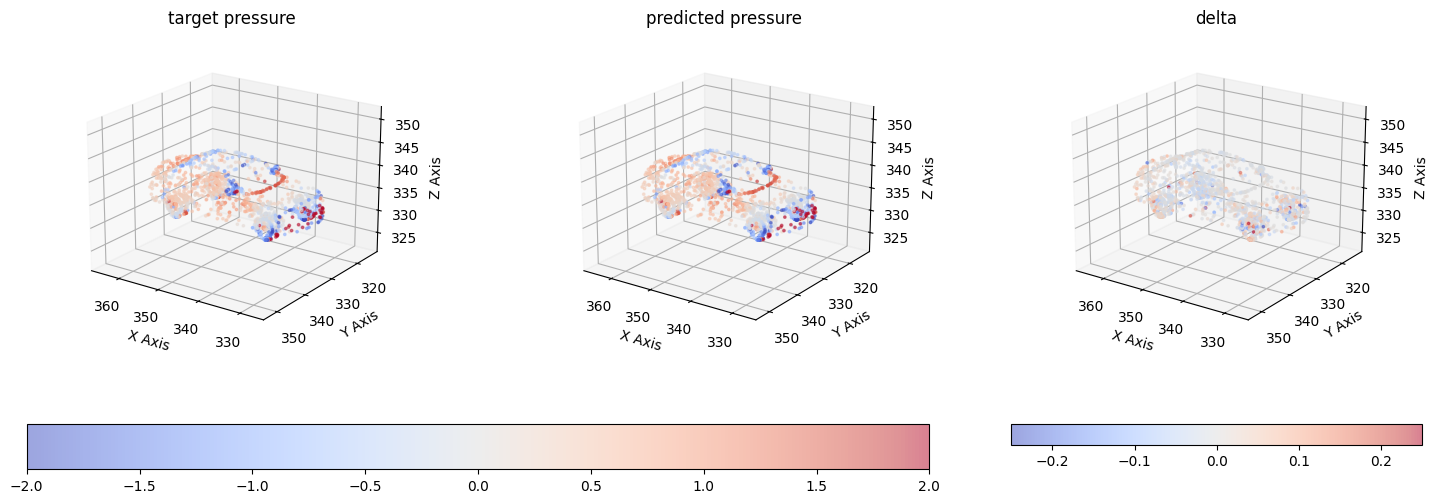

In [35]:
surface_query_positions_plot = batch["surface_query_position"].cpu().squeeze(0)
plot_pointcloud_double(
    [surface_query_positions_plot, surface_query_positions_plot],
    color=[target_surface_query_pressure.cpu().clamp(-2, 2), prediction["surface_query_pressure"].cpu().clamp(-2, 2)],
    delta_clamp=(-0.25, 0.25),
    title=["target pressure", "predicted pressure"],
    # increas this for more fidelity/larger plot
    num_points=2000,
    figsize=(18, 6),
)

### Volume x velocity

<Figure size 640x480 with 0 Axes>

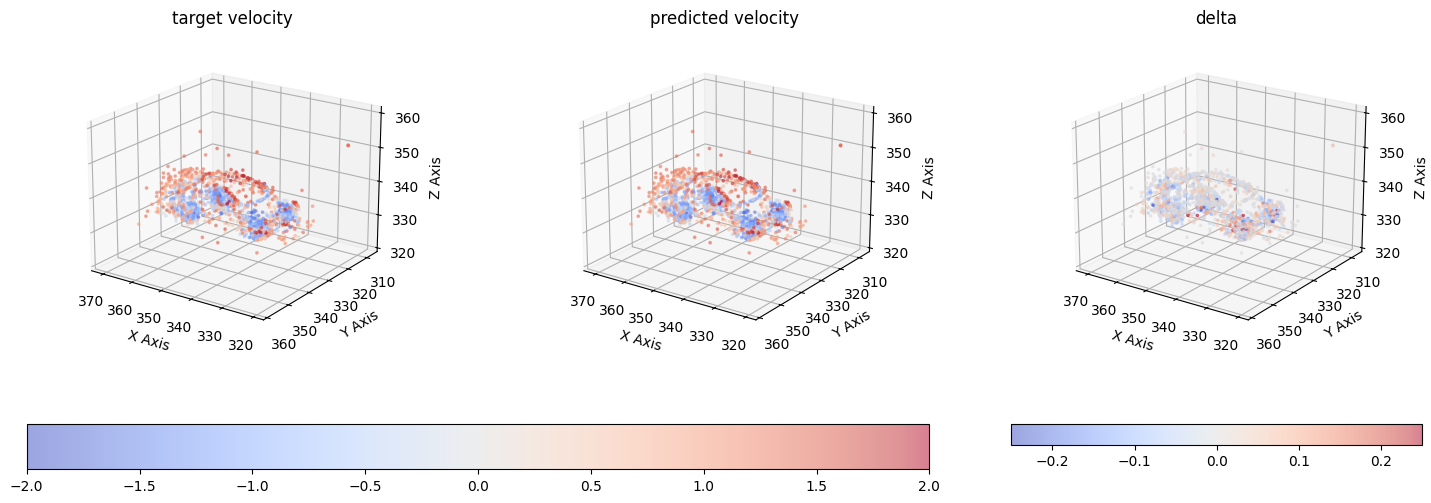

In [36]:
volume_query_positions_plot = batch["volume_query_position"].cpu().squeeze(0)
# clamp positions to see car better
volume_query_positions_plot = volume_query_positions_plot.clamp(
    torch.tensor([325, 308, 320]),
    torch.tensor([366, 358, 350]),
)
plot_pointcloud_double(
    [volume_query_positions_plot, volume_query_positions_plot],
    color=[target_volume_query_velocity.cpu()[:, 0].clamp(-2, 2), prediction["volume_query_velocity"].cpu()[:, 0].clamp(-2, 2)],
    delta_clamp=(-0.25, 0.25),
    title=["target velocity", "predicted velocity"],
    # increas this for more fidelity/larger plot
    num_points=2000,
    figsize=(18, 6),
)

## Error metrics


Mean squared error (MSE) loss in normalized space

In [37]:
surface_query_pressure_mse = nn.functional.mse_loss(prediction["surface_query_pressure"], target_surface_query_pressure)
print(surface_query_pressure_mse)

tensor(0.0043, device='cuda:0')


L2 error in denormalized space

In [38]:
# denormalize
pressure_normalizer = collator.get_preprocessor(lambda c: isinstance(c, MomentNormalizationPreprocessor) and c.items == {"surface_pressure"})
target_surface_query_pressure_denorm = pressure_normalizer.denormalize(target_surface_query_pressure)
pres_surface_query_pressure_denorm = pressure_normalizer.denormalize(prediction["surface_query_pressure"])

# L2 error
delta = target_surface_query_pressure_denorm - pres_surface_query_pressure_denorm
l2_error = delta.norm() / target_surface_query_pressure_denorm.norm()
print(l2_error)

tensor(0.0462, device='cuda:0')


Note that the error varies between individual test samples and what points are sampled; on average it is roughly 4%

## Drag & lift coefficients

To calculate drag and lift coefficients, we need some more data such as simulation specific scalars (rho, v_inf, a reference area) and cell specific data (surface normal and surface area).

In [39]:
# Define and load reference values
rho = 1.0
v_inf = 38.889
inlet_direction = torch.tensor([1, 0, 0], dtype=torch.float)
lift_direction = torch.tensor([0, 0, 1], dtype=torch.float)
reference_area = torch.tensor(pd.read_csv("../data/run_11/geo_ref_11.csv")['aRef'][0])

# extract surface normals and areas
surface_normal = torch.from_numpy(vtp.cell_normals)
surface_area = torch.from_numpy(vtp.compute_cell_sizes(length=False, volume=False)["Area"]).float()

Now we can easily calculate the drag and lift coefficients from the HRLES CFD simulations.

In [40]:
# calculate forces of the HRLES CFD simulation
target_pforce = (surface_normal.T * (surface_pressure * surface_area)).sum(dim=1)
target_sforce = -(wallshearstress.T * surface_area).sum(dim=1)
target_total_force = target_pforce + target_sforce

# calculate coefficients of the HRLES CFD simulation
target_cd = torch.dot(target_total_force, inlet_direction) / (0.5 * rho * v_inf**2 * reference_area)
target_cl = torch.dot(target_total_force, lift_direction) / (0.5 * rho * v_inf**2 * reference_area)

print(f"HRLES drag coefficient: {target_cd:.4f}")
print(f"HRLES lift coefficient: {target_cl:.4f}")

HRLES drag coefficient: 0.3159
HRLES lift coefficient: 0.1197


Now we want to predict these coefficients with AB-UPT. To do this, we need to decode the full 8M points of the surface mesh to obtain corresponding pressure and wallshearstress values.

We use the data that was previously loaded and simply plug in the full 9M surface mesh positions as surface queries.

In [41]:
# reload the batch because we modified it before
batch = collator.preprocess_inputs_only([raw_sample])
# move to gpu
batch = {key: value.to("cuda") for key, value in batch.items()}

# we dont need the volume query positions from the previously loaded batch, so we use only 1 query position to make inference faster
batch["volume_query_position"] = batch["volume_query_position"][:, :1]
# we dont use the surface position from the batch as they are downsampled
batch.pop("surface_query_position")

# normalize surface positions
position_normalizer = collator.get_preprocessor(lambda c: isinstance(c, PositionNormalizationPreprocessor))
surface_position = position_normalizer(
    [
        dict(
            surface_position_vtp=surface_position,
            volume_position=torch.randn(1, 3),
        )
    ],
)[0]["surface_position_vtp"]

In [42]:
# full inference forward pass (note that this propagates ~8M points, so it can take a while on the free colab GPUs)
# 8M points dont fit into GPU memory, so we need to chunk it
predictions = []
for surface_query_position_chunk in tqdm(surface_position.chunk(chunks=10)):
  with torch.autocast(device_type="cuda", dtype=torch.float16), torch.no_grad():
    predictions.append(abupt(surface_query_position=surface_query_position_chunk.to("cuda").unsqueeze(0), **batch))

100%|██████████| 10/10 [01:37<00:00,  9.77s/it]


In [43]:
# concatenate chunks
prediction = {}
for key in predictions[0].keys():
  if "surface_query" in key:
    # concat surface_query predictions
    prediction[key] = torch.cat([predictions[i][key] for i in range(len(predictions))])

In [44]:
# denormalize predictions
wallshearstress_normalizer = collator.get_preprocessor(lambda c: isinstance(c, MomentNormalizationPreprocessor) and c.items == {"surface_wallshearstress"})
surface_query_pressure_denorm = pressure_normalizer.denormalize(prediction["surface_query_pressure"])
surface_query_wallshearstress_denorm = wallshearstress_normalizer.denormalize(prediction["surface_query_wallshearstress"])

Now we simply replace the surface pressure and the wallshearstress with the model predictions in the coefficient formulars.

In [45]:
# calculate predicted forces
pred_pforce = (surface_normal.T * (surface_query_pressure_denorm.squeeze(-1).cpu() * surface_area)).sum(dim=1)
pred_sforce = -(surface_query_wallshearstress_denorm.cpu().T * surface_area).sum(dim=1)
pred_total_force = pred_pforce + pred_sforce
# calculate predicted coefficients
pred_cd = torch.dot(pred_total_force, inlet_direction) / (0.5 * rho * v_inf**2 * reference_area)
pred_cl = torch.dot(pred_total_force, lift_direction) / (0.5 * rho * v_inf**2 * reference_area)

print(f"AB-UPT drag coefficient: {pred_cd:.4f}")
print(f"AB-UPT lift coefficient: {pred_cl:.4f}")

AB-UPT drag coefficient: 0.3117
AB-UPT lift coefficient: 0.1180


That's pretty close to the actual value

In [46]:
print(f"HRLES drag coefficient: {target_cd:.4f}")
print(f"AB-UPT drag coefficient: {pred_cd:.4f}")
print(f"Absolute error {(target_cd - pred_cd).abs().item():.4f}")

HRLES drag coefficient: 0.3159
AB-UPT drag coefficient: 0.3117
Absolute error 0.0042


In [47]:
print(f"HRLES lift coefficient: {target_cl:.4f}")
print(f"AB-UPT lift coefficient: {pred_cl:.4f}")
print(f"Absolute error {(target_cl - pred_cl).abs().item():.4f}")

HRLES lift coefficient: 0.1197
AB-UPT lift coefficient: 0.1180
Absolute error 0.0016


## Streamline visualizations

We now plot the streamlines around the car, based on the velocity predictions. Next to that, we plot the groun truth first, to have a side-by-side comparison.

In [48]:
# load ground truth data
surface_position = dataset.getitem_surface_position_vtp(0)
volume_position = dataset.getitem_volume_position(0)
volume_velocity = dataset.getitem_volume_velocity(0)

Predict the volume velocity with AB-UPT

In [49]:
# reload the batch because we previously modified it
batch = collator.preprocess_inputs_only([raw_sample])
# remove surface queries (use only a single surface position query)
batch["surface_query_position"] = batch["surface_query_position"][:, :1]
# move batch to device
batch = {key: value.to("cuda") for key, value in batch.items()}
# create volume predictions
with torch.autocast(device_type="cuda", dtype=torch.float16), torch.no_grad():
  prediction = abupt(**batch)

In [50]:
# denormalize input positions and velocity predictions
velocity_normalizer = collator.get_preprocessor(lambda c: isinstance(c, MomentNormalizationPreprocessor) and c.items == {"volume_velocity"})
position_normalizer = collator.get_preprocessor(lambda c: isinstance(c, PositionNormalizationPreprocessor))
volume_position_query = position_normalizer.denormalize(value=batch["volume_query_position"])[0]
volume_velocity_pred = velocity_normalizer.denormalize(value=prediction["volume_query_velocity"])

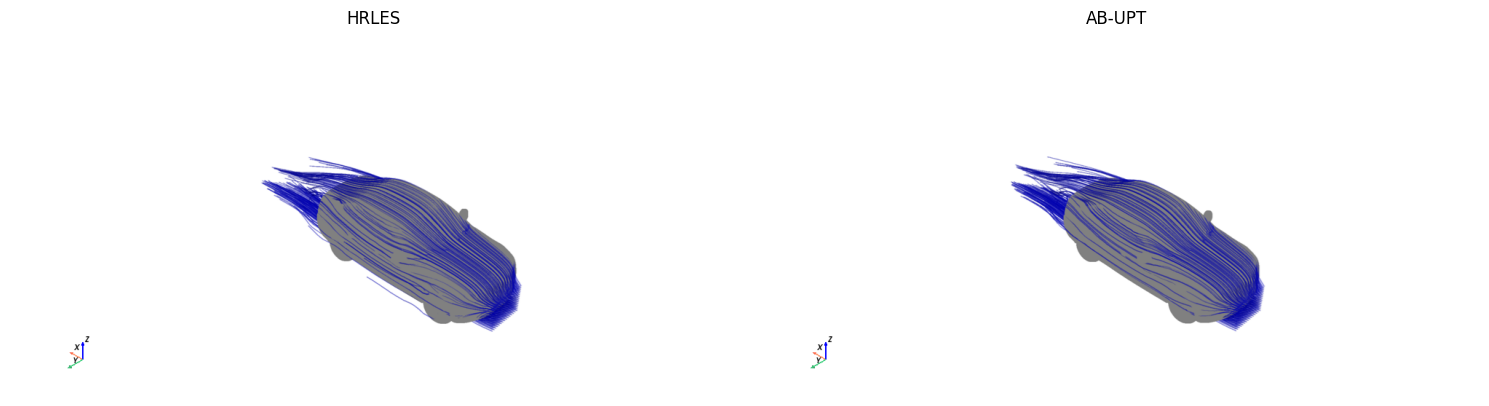

In [51]:
plot_streamlines(
    surface_position=surface_position,
    volume_position_gt=volume_position,
    volume_velocity_gt=volume_velocity,
    volume_position_pred=volume_position_query.cpu(),
    volume_velocity_pred=volume_velocity_pred.cpu(),
)